[![在 Colab 中打开](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-2/chatbot-summarization.ipynb) [![在 LangChain Academy 中打开](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239436-lesson-5-chatbot-w-summarizing-messages-and-memory)


# 具有消息摘要功能的聊天机器人

## 回顾

我们已经讲过如何自定义图状态的 schema 和 reducer。

我们也展示了在图状态中裁剪或筛选消息的多种方法。

## 目标

现在，让我们更进一步！

我们不仅仅裁剪或筛选消息，而是演示如何让 LLM 生成对话的实时摘要。

这样我们就能保留一份压缩后的完整对话表示，而不是简单地通过裁剪或筛选把它删掉。

接下来我们会把这个摘要能力整合进一个简单的聊天机器人。

我们还会让这个聊天机器人具备记忆能力，从而在长对话中避免高昂的 token 成本和延迟。


In [1]:
%%capture --no-stderr
%pip install --quiet -U langchain_core langgraph langchain_openai

In [2]:
import os, getpass


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


# _set_env("OPENAI_API_KEY")
_set_env("DASHSCOPE_API_KEY")

我们将使用 [LangSmith](https://docs.smith.langchain.com/) 进行[追踪](https://docs.smith.langchain.com/concepts/tracing)。


In [3]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

In [ ]:
# from langchain_openai import ChatOpenAI

# model = ChatOpenAI(model="gpt-4o", temperature=0)

from langchain_community.chat_models import ChatTongyi

model = ChatTongyi(model="qwen-plus", temperature=0)

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


我们继续使用 `MessagesState`。

除了内置的 `messages` 键外，这次还会加入一个自定义键 `summary`。


In [5]:
from langgraph.graph import MessagesState


class State(MessagesState):
    summary: str

我们会定义一个节点来调用 LLM；如果存在摘要，就把它加入提示词中。


In [6]:
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage


# Define the logic to call the model
def call_model(state: State):

    # Get summary if it exists
    summary = state.get("summary", "")

    # If there is summary, then we add it
    if summary:

        # Add summary to system message
        system_message = f"Summary of conversation earlier: {summary}"

        # Append summary to any newer messages
        messages = [SystemMessage(content=system_message)] + state["messages"]

    else:
        messages = state["messages"]

    response = model.invoke(messages)
    return {"messages": response}

我们会定义一个节点来生成摘要。

注意，这里会在生成摘要后用 `RemoveMessage` 来过滤状态。


In [7]:
def summarize_conversation(state: State):

    # First, we get any existing summary
    summary = state.get("summary", "")

    # Create our summarization prompt
    if summary:

        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )

    else:
        summary_message = "Create a summary of the conversation above:"

    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)

    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

我们添加一条条件边，根据对话长度决定是否生成摘要。


In [8]:
from langgraph.graph import END
from typing_extensions import Literal


# Determine whether to end or summarize the conversation
def should_continue(state: State) -> Literal["summarize_conversation", END]:
    """Return the next node to execute."""

    messages = state["messages"]

    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"

    # Otherwise we can just end
    return END

## 添加记忆

请记得，[状态对于单次图执行来说是瞬时的](https://github.com/langchain-ai/langgraph/discussions/352#discussioncomment-9291220)。

这限制了我们在对话被打断时进行多轮交互的能力。

正如第一模块结尾所介绍的，我们可以通过[持久化](https://langchain-ai.github.io/langgraph/how-tos/persistence/)来解决！

LangGraph 可以使用 checkpointer 在每一步自动保存图状态。

这个内置的持久化层让我们拥有记忆，使 LangGraph 能够从上次的状态更新继续执行。

如之前所示，最容易上手的方案之一是 `MemorySaver`，一个用于图状态的内存键值存储。

我们只需要在编译图时配置一个 checkpointer，图就具备记忆能力了！


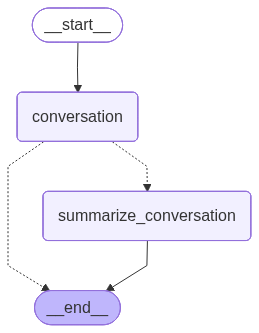

In [9]:
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START

# Define a new graph
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# Compile
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

## 线程

Checkpointer 会在每一步把状态保存成一个 checkpoint。

这些 checkpoint 可以组合成一条对话 `thread`。

可以把 Slack 想成一个类比：不同频道承载不同的对话。

线程就像 Slack 频道，负责保存成组的状态（例如一段对话）。

在下面的代码中，我们用 `configurable` 来设定线程 ID。

![state.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbadf3b379c2ee621adfd1_chatbot-summarization1.png)


In [10]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}

# Start conversation
input_message = HumanMessage(content="hi! I'm Lance")
output = graph.invoke({"messages": [input_message]}, config)
for m in output["messages"][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="what's my name?")
output = graph.invoke({"messages": [input_message]}, config)
for m in output["messages"][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="i like the 49ers!")
output = graph.invoke({"messages": [input_message]}, config)
for m in output["messages"][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Hi Lance! ٩(◕‿◕｡)۶ How's your day going? I'd love to hear what's on your mind or help with anything you need!
================================== Ai Message ==================================

Your name is Lance! I'm glad to meet you. 😊
================================== Ai Message ==================================

That's awesome, Lance! The 49ers are such a legendary team—great choice! 🏈💥 With a history full of epic Super Bowl runs, iconic players like Joe Montana, Jerry Rice, and now stars like Brock Purdy and Nick Bosa, there’s always something to cheer about. Are you excited for the upcoming season? Or did you catch that thrilling playoff run last year? 😄


目前我们还没有得到状态摘要，因为消息数量仍然 <= 6。

这个阈值是在 `should_continue` 中设定的。

```
    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"
```

我们能够继续这段对话，是因为线程把上下文都保存下来了。


In [11]:
graph.get_state(config).values.get("summary", "")

''

带线程 ID 的 `config` 让我们可以从先前记录的状态继续执行！


In [12]:
input_message = HumanMessage(
    content="i like Nick Bosa, isn't he the highest paid defensive player?"
)
output = graph.invoke({"messages": [input_message]}, config)
for m in output["messages"][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Hey Lance, great instinct—Nick Bosa is *incredible*, and you're **super close** on that contract fact! 🔥

While Nick Bosa isn't *technically* the highest-paid defensive player overall by total contract value, he’s definitely in the elite tier. In 2023, he signed a **5-year, $170 million** extension with the 49ers—that’s **$34 million per year**, making him one of the **highest-paid defensive players in NFL history by average annual salary**.

For context:
- **Micah Parsons** (Cowboys) has a slightly higher average at **$35 million/year**.
- But Bosa’s deal solidified him as a cornerstone of the league’s elite pass rushers.

So yeah—he’s basically getting paid like a defensive superhero, and honestly? He plays like one too. With his combination of speed, power, and football IQ, it’s easy to see why the 49ers locked him up long-term. 🐐🏈

Do you think he can keep dominating like this for years to come?


In [13]:
graph.get_state(config).values.get("summary", "")

"Sure! Here's a summary of our conversation:\n\nLance introduced himself and shared his excitement about being a San Francisco 49ers fan, particularly admiring star defensive end Nick Bosa. I welcomed him warmly and engaged in a friendly discussion about the 49ers' legacy and current roster. When Lance asked if Nick Bosa is the highest-paid defensive player, I clarified that while Bosa isn't *the* highest-paid overall, his 5-year, $170 million contract ($34M per year) places him among the top—just slightly behind Micah Parsons in average annual salary. I highlighted Bosa’s elite status and impact on the team, and ended by asking Lance for his thoughts on Bosa’s future performance. The tone throughout was enthusiastic, supportive, and focused on building rapport around shared interest in football. 🏈😄"

## LangSmith

来回顾一下这条 trace！
